In [23]:
import bz2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import math
import os

In [32]:
#getting started
dirname = os.path.dirname('CRISK')
BZ2 = os.path.join(dirname, 'Lichess Data\BZ2.bz2')
eco = os.path.join(dirname,'Eco Codes')
'''
One time operation - no longer necessary
#Compiling ECO data into one dataframe
letters = ['a','b','c','d','e']
frames = []
for i in range(len(letters)):
    frames.append(pd.read_csv(os.path.join(dirname, 'ECO' + '\\' + letters[i] +'.tsv'), sep='\t'))

eco_final = frames[0].append(frames[1:-1], ignore_index = True)
del frames #don't know if necessary
'''
with bz2.open(BZ2) as f:
    data = f.read()

eco_final = pd.read_csv(eco)



data = str(data) # Convert binary data into string
raw_games = data.split('[Event')

del raw_games[0] #pointless entry - not a game
del data # Remove binary string to save memory, don't know if necessary

all_games = []
for i in range(len(raw_games)):
    if raw_games[i].find('eval') != -1 or raw_games[i].find('1. ') == -1: #whether games don't start with a valid move or have eval
        continue #ignore if true
    else:
        all_games.append(raw_games[i])

del raw_games #don't know if necessary

#initialization
PGN_list = []
mode_list = []
result_list = []
avg_rating_list = []
rating_diff_list = []
termination_list = []
eco_list = []

for game in all_games:
    # PGN
    index = game.find("1. ") + 2
    while True:
        if game[index:index+2] == '0-' or game[index:index+2] == '1-' or game[index:index+2] == '1/':
            # Game termination
            break
        index += 1
    
    PGN_list.append(game[game.find("1. "):index-1])
    
    # Mode
    index = game.find("d") + 2
    s = ""
    while True:
        if game[index] == " ":
            break
        s += game[index]
        index += 1
    mode_list.append(s)
    
    # Result
    index = game.find('Result')+8
    result = game[index:index+2]
    if result == "1-":
        result_list.append("White Wins")
    elif result == "0-":
        result_list.append("Black Wins")
    elif result == "1/":
        result_list.append("Draw")
    
    # ECO Code
    index = game.find('ECO') + 5
    eco = game[index:index+3]
    eco_list.append(eco)
    
    # Rating
    wIndex = game.find('WhiteElo') + 10
    bIndex = game.find('BlackElo') + 10
    wString = ""
    while True:
        # Use a loop in case there's a rating <1000
        if game[wIndex] == '"':
            break
        wString += game[wIndex]
        wIndex += 1
    
    bString = ""
    while True:
        if game[bIndex] == '"':
            break
        bString += game[bIndex]
        bIndex += 1
    try:    
        wRating = int(wString)
        bRating = int(bString)
    except:
        wRating = np.nan   #Assign rating of 0 if rating cannot be found
        bRating = np.nan
    
    avg_rating_list.append(np.ceil((wRating+bRating)/2))
    rating_diff_list.append(wRating-bRating)
    
    # Termination
    index = game.find("[Termination")
    quotes = 0
    s = ""
    while quotes < 2:
        if game[index] == '"':
            quotes += 1
        elif quotes == 1:
            s += game[index]
        index += 1
    
    termination_list.append(s)
print('Job Done')

Job Done


In [25]:
chess_df = pd.DataFrame({})
chess_df['PGN'] = PGN_list
chess_df['Mode'] = mode_list
chess_df['Result'] = result_list
chess_df['Average Rating'] = avg_rating_list
chess_df['Rating Difference'] = rating_diff_list
chess_df['Termination Type'] = termination_list
chess_df['ECO'] = eco_list

In [26]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120691 entries, 0 to 120690
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PGN                120691 non-null  object 
 1   Mode               120691 non-null  object 
 2   Result             120691 non-null  object 
 3   Average Rating     120473 non-null  float64
 4   Rating Difference  120473 non-null  float64
 5   Termination Type   120691 non-null  object 
 6   ECO                120691 non-null  object 
dtypes: float64(2), object(5)
memory usage: 6.4+ MB


In [27]:
chess_df.iloc[-1]

PGN                  1. e4 c6 2. d4 d5 3. Nc3 dxe4 4. Nxe4 Nf6 5. N...
Mode                                                             Blitz
Result                                                      Black Wins
Average Rating                                                    1753
Rating Difference                                                  -18
Termination Type                                          Time forfeit
ECO                                                                B15
Name: 120690, dtype: object

In [33]:
eco_final

,eco,name,fen,moves
0,A00,Amar Gambit,rn1qkbnr/ppp2ppp/8/3p4/5p2/6PB/PPPPP2P/RNBQK2R...,g1h3 d7d5 g2g3 e7e5 f2f4 c8h3 f1h3 e5f4
1,A00,Amar Opening,rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b...,g1h3
2,A00,Amar Opening: Gent Gambit,rn1qkbnr/ppp2ppp/8/3p4/8/6PB/PPPPP3/RNBQ1RK1 b...,g1h3 d7d5 g2g3 e7e5 f2f4 c8h3 f1h3 e5f4 e1g1 f...
3,A00,Amar Opening: Paris Gambit,rnbqkbnr/ppp2ppp/8/3pp3/5P2/6PN/PPPPP2P/RNBQKB...,g1h3 d7d5 g2g3 e7e5 f2f4
4,A00,Amsterdam Attack,r1bqkb1r/ppp2ppp/2np1n2/4p3/2P5/1PN1P3/P2P1PPP...,e2e3 e7e5 c2c4 d7d6 b1c3 b8c6 b2b3 g8f6
...,...,...,...,...
3105,D97,"Grünfeld Defense: Russian Variation, Szabo (Bo...",rnbq1rk1/pp2ppbp/2p2np1/8/2QPP3/2N2N2/PP3PPP/R...,d2d4 g8f6 c2c4 g7g6 b1c3 d7d5 g1f3 f8g7 d1b3 d...
3106,D98,"Grünfeld Defense: Russian Variation, Keres Var...",r2q1rk1/ppp1ppbp/1nn3p1/8/3PP1b1/2NQBN2/PP2BPP...,d2d4 g8f6 c2c4 g7g6 b1c3 d7d5 g1f3 f8g7 d1b3 d...
3107,D98,"Grünfeld Defense: Russian Variation, Smyslov V...",rn1q1rk1/ppp1ppbp/5np1/8/2QPP1b1/2N2N2/PP3PPP/...,d2d4 g8f6 c2c4 g7g6 b1c3 d7d5 g1f3 f8g7 d1b3 d...
3108,D99,"Grünfeld Defense: Russian Variation, Smyslov V...",rn1q1rk1/pppnppbp/6p1/8/3PP1b1/1QN1BN2/PP3PPP/...,d2d4 g8f6 c2c4 g7g6 b1c3 d7d5 g1f3 f8g7 d1b3 d...


In [29]:
eco_final[eco_final['name'].apply(lambda x: True if 'queen\'s gambit' in x.lower() else False)]['eco']
#eco codes for openings with queen's gambit in name

208     A04
2681    D02
2682    D02
2707    D06
2708    D06
       ... 
3037    D67
3038    D68
3039    D68
3040    D68
3041    D69
Name: eco, Length: 219, dtype: object

<AxesSubplot:xlabel='Average Rating', ylabel='Density'>

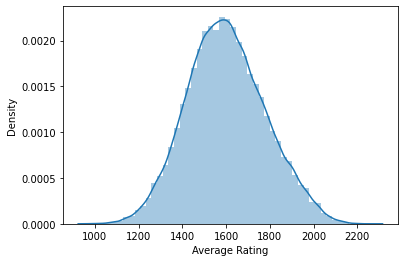

In [34]:
sb.distplot(chess_df['Average Rating'])